# HM model (working ?)

In [1]:
import numpy as np
import emcee
import matplotlib.pyplot as plt

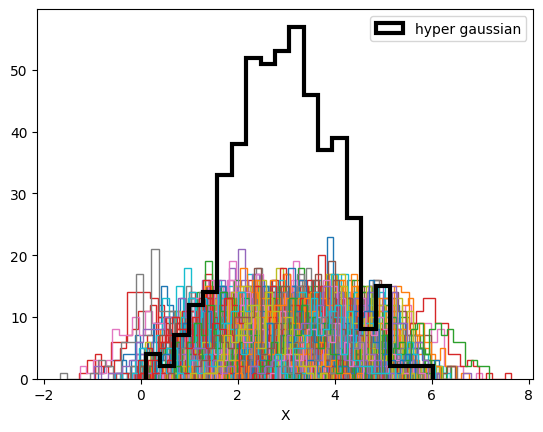

In [2]:
def generate_data(mean, scale, size):
    """
    Function to generate a Gaussian distribution with specified mean, scale and size. 
    """
    return np.random.normal(loc=mean, scale=scale, size=size)

# True parameters for the parent + child Gaussian distribution

true_parent_mean = 3.0 # hyperparameter
true_parent_scale = 1 # hyperparameter
true_child_scale = 0.5

N_obs = 500
size_child = 100

# Hypothesis for parent gaussian 
parent_gaussian = generate_data(true_parent_mean, true_parent_scale, size=N_obs)

child_gaussian = np.random.normal(loc=parent_gaussian[:, np.newaxis], scale=true_child_scale, size=(N_obs, size_child))

for i in range(N_obs):
    plt.hist(child_gaussian[i], fill=False, histtype='step', bins=20)
plt.hist(parent_gaussian, fill=False, histtype='step', color='black',linewidth=3, label='hyper gaussian', bins=20)
plt.xlabel("X")
plt.legend()

In [3]:
def log_likelihood(params):
    parent_mean, parent_scale = params
    weights = np.log(np.sum(
                (2 * np.pi * true_child_scale**2)**(-0.5) * \
                np.exp(-(child_gaussian - np.expand_dims(child_gaussian.mean(axis=1), axis=1))**2 / \
                (2 * true_child_scale**2)),
                axis=1))
    chi_sq = ((child_gaussian.mean(axis=1) - parent_mean) / (2 * parent_scale))**2
    return - 0.5 * N_obs * np.log(2 * np.pi * parent_scale**2 * size_child**2) - np.sum(chi_sq + weights)

In [4]:
from scipy.optimize import minimize

np.random.seed(42)
nll = lambda *args: -log_likelihood(*args)
initial = np.array([true_parent_mean, true_parent_scale]) + 0.1 * np.random.randn(2)
soln = minimize(nll, initial)
mu_ml, sigma_ml = soln.x
    
print("Maximum likelihood estimates:")
print("mu = {0:.3f}".format(mu_ml))
print("sigma = {0:.3f}".format(sigma_ml))

Maximum likelihood estimates:
mu = 2.974
sigma = 0.724


In [5]:
def log_prior(params):
    parent_mean, parent_scale = params
    # Flat priors 
    if (0 < parent_mean < 5 and 
        0 < parent_scale < 5):
        return 0.0
    return -np.inf

def log_probability(params):
    log_prior_val = log_prior(params)
    if not np.isfinite(log_prior_val):
        return -np.inf
    return log_prior_val + log_likelihood(params)

In [6]:
import emcee

pos = soln.x + 1e-6 * np.random.randn(50, 2)
nwalkers, ndim = pos.shape

sampler = emcee.EnsembleSampler(
    nwalkers, ndim, log_probability
)
sampler.run_mcmc(pos, 5000, progress=True)

  0%|          | 0/5000 [00:00<?, ?it/s]

100%|██████████| 5000/5000 [01:07<00:00, 74.48it/s]


State([[2.98822913 0.69261135]
 [3.00111001 0.68436831]
 [3.04975334 0.72100201]
 [2.94119391 0.71159442]
 [2.96211507 0.73821564]
 [3.02110327 0.78358285]
 [2.96166857 0.73579484]
 [2.87460726 0.74602822]
 [2.96483054 0.70943866]
 [2.9603781  0.69833913]
 [3.06190848 0.72521865]
 [2.99900783 0.7120004 ]
 [3.01626276 0.72924228]
 [2.93653912 0.69975269]
 [2.93881104 0.74378103]
 [3.00308335 0.74099861]
 [3.0412066  0.72687337]
 [2.96784034 0.69413624]
 [2.95285149 0.73387049]
 [2.9812337  0.7042316 ]
 [3.07727709 0.71494014]
 [3.02428506 0.74162017]
 [2.95939397 0.72799416]
 [2.95711945 0.74059592]
 [2.95983528 0.73227809]
 [2.95368803 0.70375536]
 [3.01784242 0.72072651]
 [3.00446152 0.68823321]
 [2.93806821 0.78282793]
 [2.92140479 0.71021108]
 [2.88556772 0.71863546]
 [2.8557785  0.78507639]
 [2.95344604 0.69660346]
 [2.90695105 0.69062057]
 [2.80845503 0.73386143]
 [2.94638162 0.77170716]
 [2.91874584 0.70513729]
 [2.94464359 0.76504916]
 [2.94700448 0.75312499]
 [3.01689025 0.7250

Text(0.5, 0, 'step number')

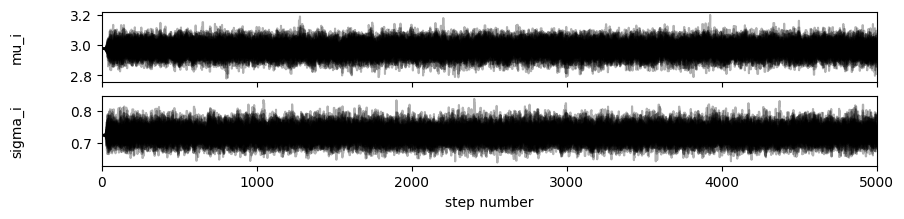

In [7]:
fig, axes = plt.subplots(2, figsize=(10, 2), sharex=True)
samples = sampler.get_chain()
labels = ["mu_i", "sigma_i"]
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number")

In [8]:
tau = sampler.get_autocorr_time()
print(tau)

[30.31512329 29.9554384 ]


In [9]:
flat_samples = sampler.get_chain(discard=100, thin=15, flat=True)
print(flat_samples.shape)

(16300, 2)


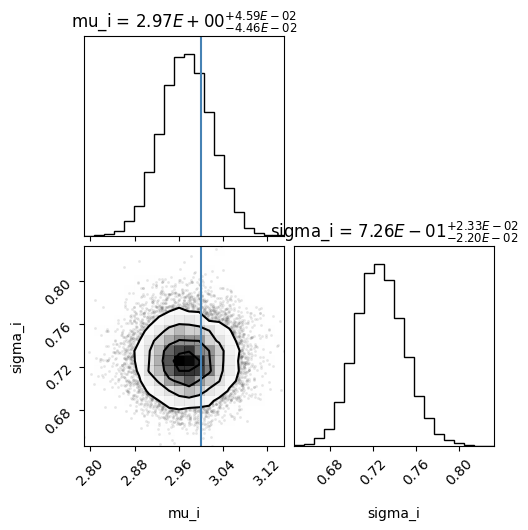

In [10]:
import corner

fig = corner.corner(
    flat_samples, labels=labels, truths=[true_parent_mean, true_parent_scale], title_fmt=".2E", show_titles=True, title_kwargs={'fontsize':12}
)